# Detecting eye diseases with DL
Globally, more than 1 billion people are affected by vision impairment or blindness due to unaddressed cataracts (65.2 million), glaucoma (6.9 million), and retina disease (3 million).

This notebook shows how to use the fast.ai framework to detect eye diseases




## Config

In [1]:
# install kaggle cli
# !pip install kaggle-cli
from fastai.vision import *


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
PROJECT_PATH = Path('./gdrive/My Drive//we-make-ai/Projekte/cv_eye_disease_diagnosis/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
PROJECT_PATH = Path('./')
DATA_PATH = PROJECT_PATH/'data/dataset/'

In [3]:
DATA_PATH.ls()

[PosixPath('data/dataset/normal'),
 PosixPath('data/dataset/cataract'),
 PosixPath('data/dataset/retina_disease'),
 PosixPath('data/dataset/glaucoma')]

## Create Dataset

In [4]:
import glob
import pandas as pd
normal_fnames = glob.glob(str(DATA_PATH/'normal/*.png'))
cataract_fnames = glob.glob(str(DATA_PATH/'cataract/*.png'))
glaucoma_fnames = glob.glob(str(DATA_PATH/'glaucoma/*.png'))
retina_disease_fnames = glob.glob(str(DATA_PATH/'retina_disease/*.png'))
normal = [(filename, 'normal') for filename in normal_fnames]
cataract = [(filename, 'cataract') for filename in cataract_fnames]
glaucoma = [(filename, 'glaucoma') for filename in glaucoma_fnames]
retina_disease = [(filename, 'retina_disease') for filename in retina_disease_fnames]

filenames_df = pd.DataFrame(normal+cataract+glaucoma+retina_disease, columns=['name', 'label'])

In [5]:
filenames_df.head()

,name,label
0,data/dataset/normal/NL_030.png,normal
1,data/dataset/normal/NL_300.png,normal
2,data/dataset/normal/NL_012.png,normal
3,data/dataset/normal/NL_130.png,normal
4,data/dataset/normal/NL_069.png,normal


In [23]:
filenames_df.to_csv('fnames.csv')

In [6]:
tfms = get_transforms()

In [7]:
bs = 32
data = (ImageList.from_df(filenames_df, PROJECT_PATH)
        .split_by_rand_pct(0.15)
        .label_from_df(cols='label')        
        .transform(tfms, size=128)
        .databunch(bs=bs)
       )

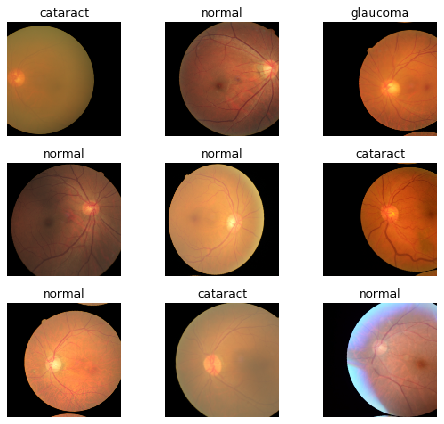

In [75]:
data.show_batch(rows=3, figsize=(7,6))

# Create the learner

In [8]:
learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics=accuracy, 
                    model_dir=PROJECT_PATH/'models/'
                   )

In [9]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.194687,1.560759,0.477778,00:18
1,1.918788,1.485499,0.522222,00:18
2,1.804194,1.277696,0.611111,00:18
3,1.680061,1.275408,0.555556,00:18
4,1.569528,1.207229,0.544444,00:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


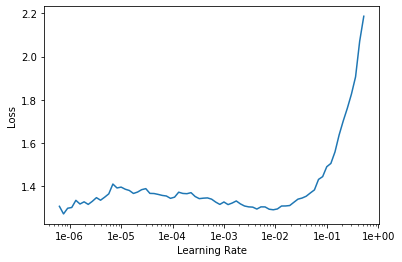

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.301071,1.205538,0.544444,00:18
1,1.326323,1.199077,0.566667,00:18
2,1.309020,1.200672,0.544444,00:18
3,1.327238,1.205562,0.544444,00:18
4,1.340574,1.188672,0.544444,00:18
5,1.336011,1.171185,0.566667,00:18
6,1.342687,1.206981,0.544444,00:18
7,1.317590,1.184653,0.555556,00:18
8,1.333239,1.214653,0.533333,00:18
9,1.350616,1.185728,0.566667,00:18


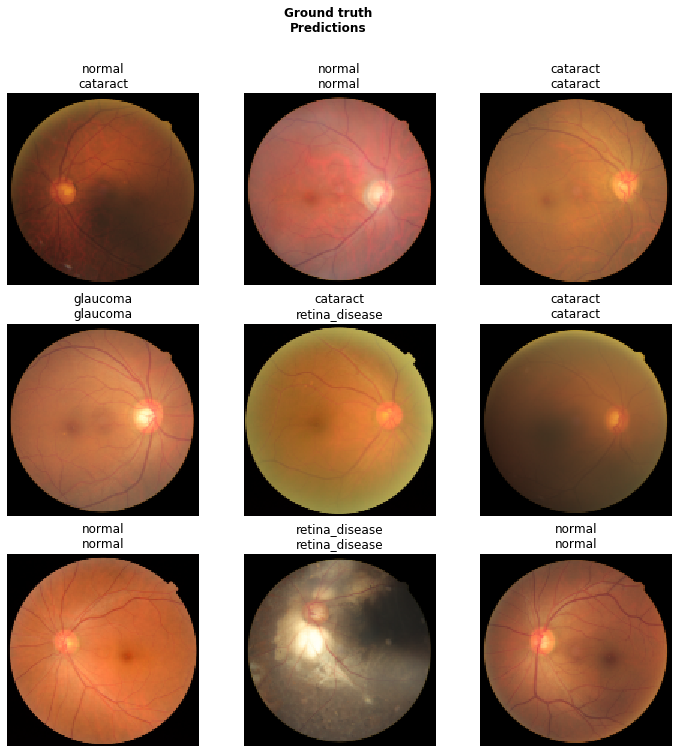

In [12]:
learn.show_results(rows=3)

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

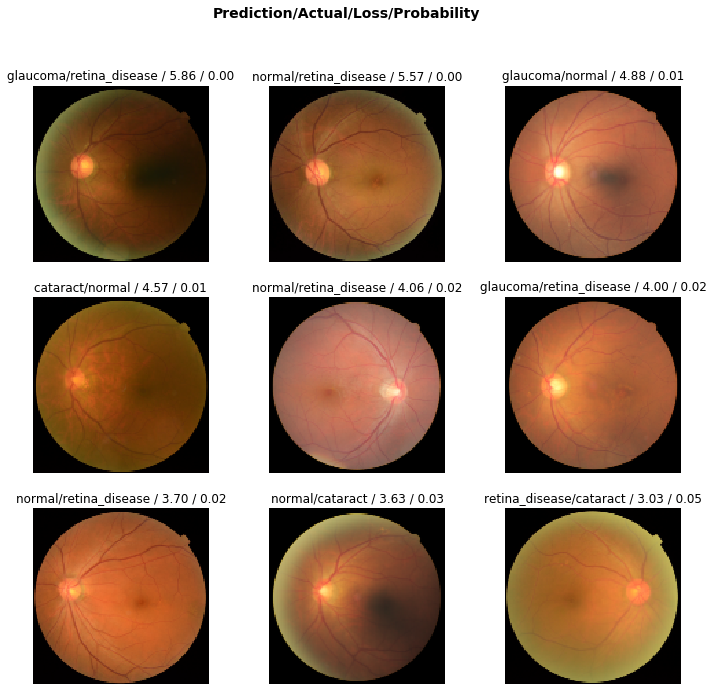

In [15]:
interp.plot_top_losses(9, figsize=(12,11))

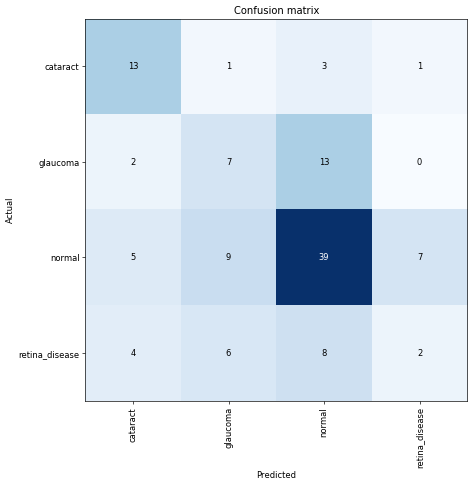

In [90]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

# Unfreezing, fine-tuning, and learning rates¶

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.797539,2.036038,0.388889,00:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


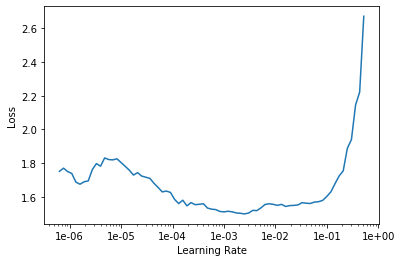

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(100, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.774420,1.876812,0.366667,00:18
1,1.715585,1.795514,0.411111,00:17
2,1.668946,1.723415,0.433333,00:18
3,1.618563,1.650308,0.433333,00:18
4,1.592084,1.588990,0.411111,00:18
5,1.572799,1.448480,0.466667,00:18
6,1.532775,1.407308,0.466667,00:18
7,1.528871,1.381248,0.455556,00:18
8,1.473294,1.362796,0.444444,00:18
9,1.379918,1.362397,0.466667,00:18


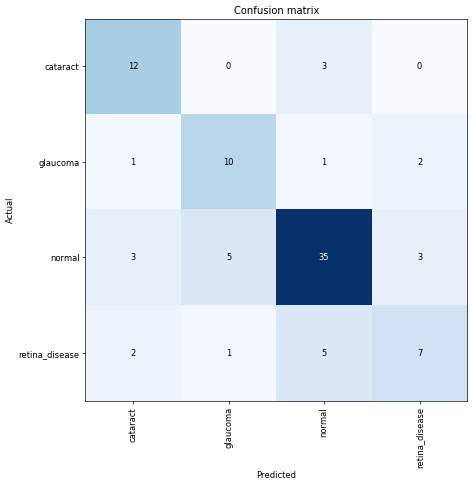

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [20]:
learn.save('model_resnet34_unfreezed')

# Export Model, put in Action

In [21]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(PROJECT_PATH)

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)